# **PyTorch Vision Transformer**

## **Getting Setup**

### **Imports**

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not found in current environment.")
    !pip install torch torchvision torchaudio --quiet
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install torchinfo --quiet
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3849, done.
remote: Counting objects: 100% (3849/3849), done.
remote: Compressing objects: 100% (1571/1571), done.
remote: Total 3849 (delta 2255), reused 3754 (delta 2217), pack-reused 0
Receiving objects: 100% (3849/3849), 647.06 MiB | 18.30 MiB/s, done.
Resolving deltas: 100% (2255/2255), done.
Updating files: 100% (248/248), done.


### **Device Agnostic Code**

In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### **Download and Extract Data**

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(
    source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination = "pizza_steak_sushi"
)

# Print the image path
print(image_path)

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...
data/pizza_steak_sushi


### **Set up Paths**

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## **Create Datasets and DataLoaders**

### **Manual Transforms**

In [6]:
# Initiaialize image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Print the transforms
print(f"Manually created transforms:\n{manual_transforms}")

Manually created transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### **Images to DataLoader**

In [7]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

# View the loaders and data
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a4452b97cd0>,
 ['pizza', 'steak', 'sushi'])

### **Visualize Image**

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

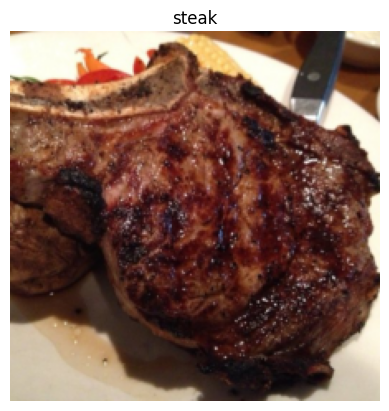

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## **ViT Model Replication**

### **Split Data to Patches**

In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size ** 2)
print(f"Number of patches (N) with image height (H = {height}), width (W = {width}) and patch size (P = {patch_size}): {number_of_patches}")

Number of patches (N) with image height (H = 224), width (W = 224) and patch size (P = 16): 196


### **Embedding Layers**

In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

# Input and output size for the embedding layer
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [12]:
# Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    # Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int = 3,
                 patch_size:int = 16,
                 embedding_dim:int = 768):
        super().__init__()

        # Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(
            in_channels = in_channels,
            out_channels = embedding_dim,
            kernel_size = patch_size,
            stride = patch_size,
            padding = 0
        )

        # Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(
            start_dim = 2,
            end_dim = 3
        )

    # Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [13]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(
    PatchEmbedding(),
    input_size = random_input_image,
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [14]:
# Set random seeds
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels = 3,
    patch_size = patch_size,
    embedding_dim = 768
)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad = True
)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension),
    requires_grad = True
)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### **Multi-Head Attention**

In [15]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    # 2. Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim:int = 768, # Hidden size D for ViT-Base
                 num_heads:int = 12, # Heads for ViT-Base
                 attn_dropout:float = 0):
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim = embedding_dim,
            num_heads = num_heads,
            dropout = attn_dropout,
            batch_first = True
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query = x, # query embeddings
            key = x, # key embeddings
            value = x, # value embeddings
            need_weights = False
        )

        # Return the output of the attention head
        return attn_output

In [16]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim = 768,
    num_heads = 12
)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [17]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    # 2. Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim:int = 768, # Hidden Size D for ViT-Base
                 mlp_size:int = 3072, # MLP size for ViT-Base
                 dropout:float = 0.1): # Dropout from for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim, out_features = mlp_size),
            nn.GELU(),

            nn.Dropout(p = dropout),

            nn.Linear(in_features = mlp_size, out_features = embedding_dim),

            nn.Dropout(p = dropout)
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        # Get the output of the MLP block
        x = self.layer_norm(x)
        x = self.mlp(x)

        # Return the output
        return x

In [18]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(
    embedding_dim = 768,
    mlp_size = 3072,
    dropout = 0.1
)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### **Transformer Encoder Block**

In [19]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim:int = 768, # Hidden size D from for ViT-Base
                 num_heads:int = 12, # Heads from for ViT-Base
                 mlp_size:int = 3072, # MLP size from for ViT-Base
                 mlp_dropout:float = 0.1, # Amount of dropout for dense layers from for ViT-Base
                 attn_dropout:float = 0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim = embedding_dim,
            num_heads = num_heads,
            attn_dropout = attn_dropout
        )

        # 4. Create MLP block
        self.mlp_block =  MLPBlock(
            embedding_dim = embedding_dim,
            mlp_size = mlp_size,
            dropout = mlp_dropout
        )

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        # Return the output of the encoder head
        return x

In [20]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(
    model = transformer_encoder_block,
    input_size = (1, 197, 768), # (batch_size, num_patches, embedding_dimension)
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [21]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model = 768, # Hidden size D for ViT-Base
    nhead = 12, # Heads for ViT-Base
    dim_feedforward = 3072, # MLP size for ViT-Base
    dropout = 0.1, # Amount of dropout for dense layers for ViT-Base
    activation = "gelu", # GELU non-linear activation
    batch_first = True,
    norm_first = True
)

# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(
    model = torch_transformer_encoder_layer,
    input_size = (1, 197, 768), # (batch_size, num_patches, embedding_dimension)
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

### **ViT Model**

In [22]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    # 2. Initialize the class with hyperparameters
    def __init__(self,
                 img_size:int = 224, # Training resolution from in ViT paper
                 in_channels:int = 3, # Number of channels in input image
                 patch_size:int = 16, # Patch size
                 num_transformer_layers:int = 12, # Layers from for ViT-Base
                 embedding_dim:int = 768, # Hidden size D from for ViT-Base
                 mlp_size:int = 3072, # MLP size from for ViT-Base
                 num_heads:int = 12, # Heads from for ViT-Base
                 attn_dropout:float = 0, # Dropout for attention projection
                 mlp_dropout:float = 0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float = 0.1, # Dropout for patch and position embeddings
                 num_classes:int = 1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width / patch^2)
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data = torch.randn(1, 1, embedding_dim),
            requires_grad = True
        )

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data = torch.randn(1, self.num_patches + 1, embedding_dim),
            requires_grad = True
        )

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels = in_channels,
            patch_size = patch_size,
            embedding_dim = embedding_dim
        )

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
            embedding_dim = embedding_dim,
            num_heads = num_heads,
            mlp_size = mlp_size,
            mlp_dropout = mlp_dropout
        ) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim, out_features = num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim = 1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [23]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [24]:
# Set random seed
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes = len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [25]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(
    model = vit,
    input_size = (32, 3, 224, 224), # (batch_size, color_channels, height, width)
    # col_names=["input_size"], # uncomment for smaller output
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## **Training Code**

### **Training**

In [26]:
# Import
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(
    params = vit.parameters(),
    lr = 3e-3,
    betas = (0.9, 0.999),
    weight_decay = 0.3
)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(
    model = vit,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1948 | train_acc: 0.3633 | test_loss: 5.1218 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9518 | train_acc: 0.3320 | test_loss: 1.6203 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7584 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2244 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


### **Loss Curves**

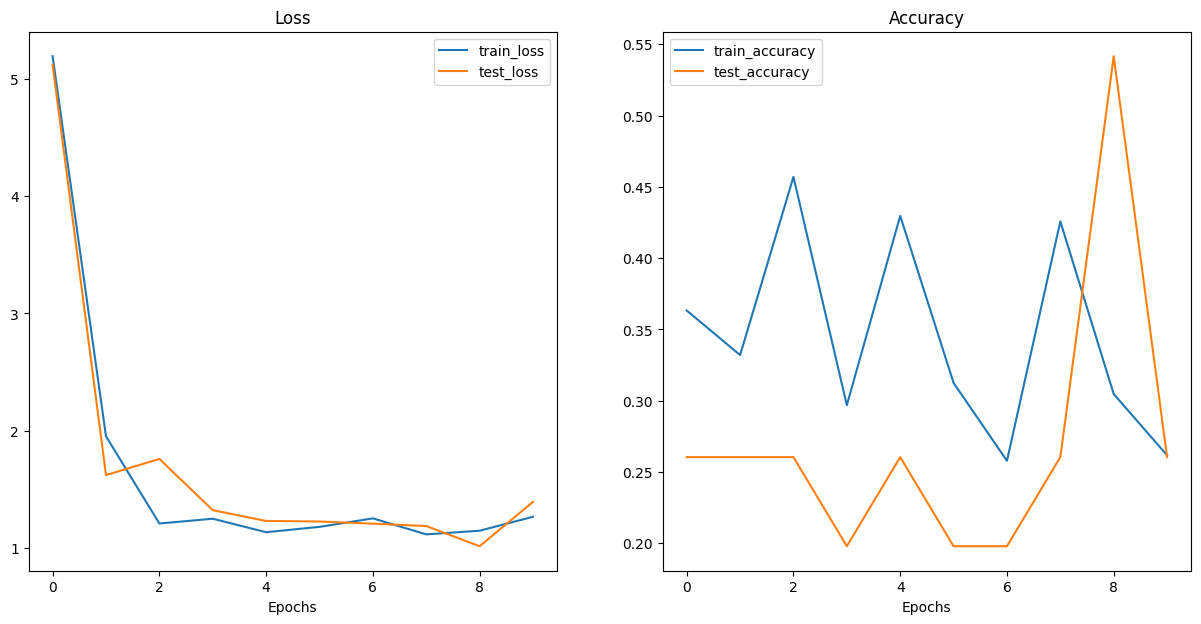

In [27]:
# Import
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## **Pretrained ViT Model**

In [28]:
# Imports
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [29]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [30]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 61.4MB/s]


In [31]:
# Print a summary using torchinfo (uncomment for actual output)
summary(
    model = pretrained_vit,
    input_size = (32, 3, 224, 224), # (batch_size, color_channels, height, width)
    # col_names = ["input_size"], # uncomment for smaller output
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [32]:
# Imports
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(
    source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination = "pizza_steak_sushi"
)

# Print the image path
print(image_path)

[INFO] data/pizza_steak_sushi directory exists, skipping download.
data/pizza_steak_sushi


In [34]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# Print the path
print(train_dir)
print(test_dir)

data/pizza_steak_sushi/train
data/pizza_steak_sushi/test


In [35]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [36]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = pretrained_vit_transforms,
    batch_size = 32
)

In [37]:
# Import
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(
    params = pretrained_vit.parameters(),
    lr = 1e-3
)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(
    model = pretrained_vit,
    train_dataloader = train_dataloader_pretrained,
    test_dataloader = test_dataloader_pretrained,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


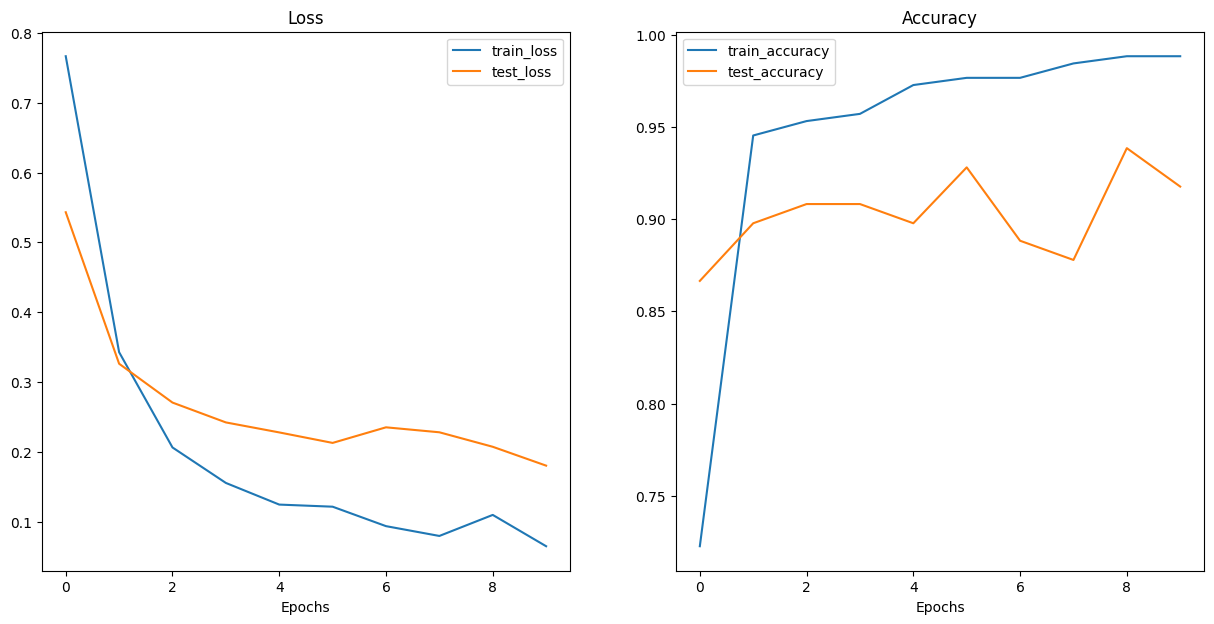

In [38]:
# Imports
from helper_functions import plot_loss_curves

# Plot the loss curves
plot_loss_curves(pretrained_vit_results)

In [39]:
# Import
from going_modular.going_modular import utils

# Save the model
utils.save_model(
    model = pretrained_vit,
    target_dir = "models",
    model_name = "07_pretrained_vit_feature_extractor_pizza_steak_sushi.pth"
)

[INFO] Saving model to: models/07_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [40]:
# Import
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/07_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


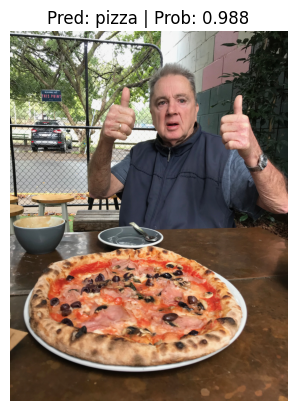

In [41]:
# Import
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(
    model = pretrained_vit,
    image_path = custom_image_path,
    class_names = class_names
)